<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
#For use during testing:
#!pip install leidenalg
#!pip install --index-url https://test.pypi.org/simple/ modisco

!pip install modisco

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
import os

## Grab the input data

In [21]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [3]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict
import numpy as np

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #len(fasta_sequences) #100 #since this is just a test run, for speed I am limiting to 100 sequences
#reverse-complement some of the sequences to simulate that
take_rc = (np.random.RandomState(1234).uniform(size=n) > 0.5)
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                            for x,rc in zip(f['contrib_scores'][task][:n], take_rc)]
    task_to_hyp_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                                for x,rc in zip(f['hyp_contrib_scores'][task][:n], take_rc)]

onehot_data = [one_hot_encode_along_channel_axis(seq) if not rc else
               one_hot_encode_along_channel_axis(seq)[::-1,::-1]
               for seq,rc in zip(fasta_sequences[:n], take_rc)]

Double check by plotting

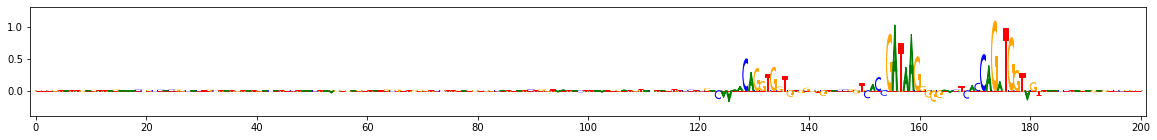

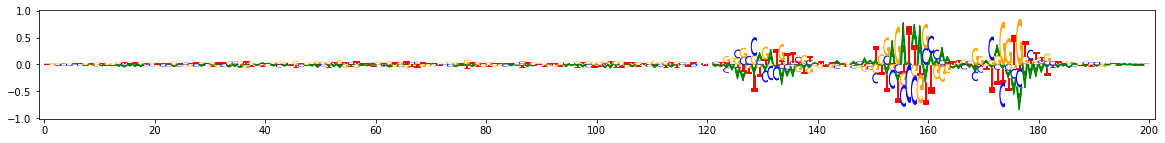

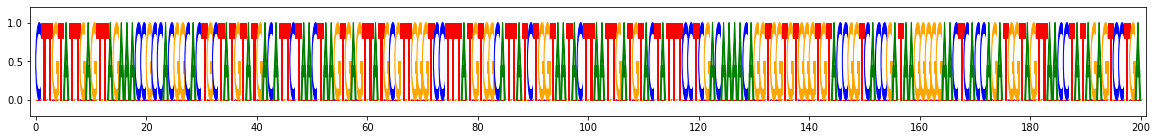

In [24]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. If all three tasks are specified under "task_names", then there will be 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). If only task0 is specified, there will only be two possible metaclusters (+1 and -1). In recent years, we have moved towards running tfmodisco on a single task at a time, which is why the example below just uses task0 (which turns up both the TAL and GATA motifs).

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.131899392
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02277598052151734
Computing threshold
For increasing = True , the minimum IR precision was 0.14668684157935308 occurring at 7.078051567077637e-06 implying a frac_neg of 0.17190270668138782
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4483100377790805 occurring at -1.0013580322265625e-05 implying a frac_neg of 0.812612279502665
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -1.0124836564064026  and  0.898599348962307 with frac passing 0.15951612903225806
Final raw thresholds are -1.0124836564064026  and  0.898599348962307
Final transformed thresholds are -0.8494086021505376  and  0.8400537634408602


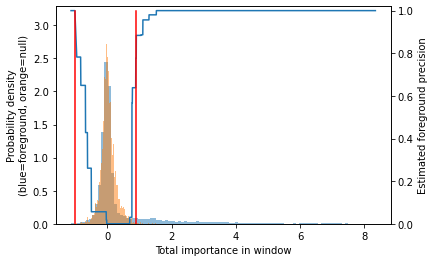

Got 198 coords
After resolving overlaps, got 198 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8399537634408603
MEMORY 0.14034944
198 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [195]
Idx to activities:  {0: '1'}
MEMORY 0.140357632
On metacluster 0
Metacluster size 195
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
Running MEME
Command: meme meme_out/metacluster0/inp_seqlets.fa -dna -mod zoops -nmotifs 10 -minw 6 -maxw 50 -objfun classic -revcomp -markov_order 0 -oc meme_out/metacluster0
Duration of MEME: 6.701524972915649 seconds
Skipping motif CGCAGGCG as e-value 140000.0 does not meet threshold of 0.05
Skipping motif CCCGCG as e-value 260000.0 does not meet threshold of 0.05
Skipping motif GTAGCCTC as e-value 380000.0 does not meet threshold of 0.05
Skipping motif CGGTGC as e-value 450000.0 does not meet threshold of 0.05
Skipping motif GGCACG as e

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 195 out of 195 | elapsed:    4.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 176 out of 195 | elapsed:    3.3s remaining:    0.4s
[Parallel(n_jobs=10)]: Done 195 out of 195 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.037534236907958984 s
Constructing csr matrix...
csr matrix made in 0.0361180305480957 s
Finished embedding computation in 9.24 s
MEMORY 0.224272384
Starting affinity matrix computations
MEMORY 0.224272384
Batching in slices of size 195


[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    0.4s finished
100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

Finished affinity matrix computations in 1.54 s
MEMORY 0.224374784
(Round 1) Computed coarse affmat
MEMORY 0.224374784
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.224374784
Launching nearest neighbors affmat calculation job
MEMORY 0.224403456


Parallel runs completed
MEMORY 0.236900352
Job completed in: 0.44 s
MEMORY 0.236900352
Launching nearest neighbors affmat calculation job
MEMORY 0.236900352
Parallel runs completed
MEMORY 0.239755264
Job completed in: 0.43 s
MEMORY 0.239755264
(Round 1) Computed affinity matrix on nearest neighbors in 0.97 s
MEMORY 0.240402432
Filtered down to 192 of 195
(Round 1) Retained 192 rows out of 195 after filtering
MEMORY 0.240607232
(Round 1) Computing density adapted affmat
MEMORY 0.240607232
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 0.243638272
Beginning preprocessing + Leiden
initclusters length: 192
Affmat shape: 192


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.5s


Quality: 0.06280247903721797


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 192


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.2s


Got 2 clusters after round 1
Counts:
{0: 105, 1: 87}
MEMORY 0.243712
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.243712
Aggregating for cluster 0 with 105 seqlets
MEMORY 0.243712
Skipped 1 seqlets that went over the sequence edge during flank expansion


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.8s finished


Skipped 12 seqlets that went over sequence edge during flank expansion
Skipped 5 due to duplicates
Trimming eliminated 0 seqlets out of 87
Skipped 13 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 87 seqlets
MEMORY 0.24385536
Skipped 8 seqlets that went over sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 78
Skipped 2 seqlets that went over the sequence edge during flank expansion
Of 150 seqlets, cluster assignments are: Counter({0: 148, -1: 2})
Aggregating for cluster 0 with 148 seqlets
MEMORY 0.243945472
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 147
Skipped 5 seqlets that went over the sequence edge during flank expansion
(Round 2) num seqlets: 150
(Round 2) Computing coarse affmat
MEMORY 0.244068352
Beginning embedding computation
MEMORY 0.244068352


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 131 out of 150 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    2.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.027309656143188477 s
Constructing csr matrix...
csr matrix made in 0.028283119201660156 s
Finished embedding computation in 6.23 s
MEMORY 0.24502272
Starting affinity matrix computations
MEMORY 0.24502272
Batching in slices of size 150


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

Finished affinity matrix computations in 1.53 s
MEMORY 0.245116928
(Round 2) Computed coarse affmat
MEMORY 0.245116928
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.245116928
Launching nearest neighbors affmat calculation job
MEMORY 0.245116928


Parallel runs completed
MEMORY 0.250310656
Job completed in: 0.36 s
MEMORY 0.250310656
Launching nearest neighbors affmat calculation job
MEMORY 0.250310656
Parallel runs completed
MEMORY 0.250904576
Job completed in: 0.32 s
MEMORY 0.250904576
(Round 2) Computed affinity matrix on nearest neighbors in 0.76 s
MEMORY 0.250904576
Not applying filtering for rounds above first round
MEMORY 0.250904576
(Round 2) Computing density adapted affmat
MEMORY 0.250904576
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 0.252370944
Beginning preprocessing + Leiden
initclusters length: 150
Affmat shape: 150


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s


Quality: 0.06974736827976881


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 150


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s


Got 2 clusters after round 2
Counts:
{0: 76, 1: 74}
MEMORY 0.25237504
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.25237504
Aggregating for cluster 0 with 76 seqlets
MEMORY 0.25237504
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 75
Aggregating for cluster 1 with 74 seqlets
MEMORY 0.252403712


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.7s finished


Trimming eliminated 0 seqlets out of 74
Got 2 clusters
Splitting into subclusters...
MEMORY 0.252506112
Inspecting pattern 0 for spurious merging
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 0.437607
Beginning preprocessing + Leiden
Affmat shape: 75


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  56 out of  75 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s


Quality: 0.1282293842794943
Got subclusters: Counter({0: 23, 2: 19, 1: 19, 3: 14})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.6s finished


Numbers for each pattern pre-subsample: [23, 19, 19, 14]
Numbers after subsampling: [23, 19, 19, 14]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.07744526863098145 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.051300048828125 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.049952030181884766 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.05073904991149902 s
Cluster sizes
[23 19 19 14]
Cross-contamination matrix:
[[1.   0.71 0.78 0.46]
 [0.58 1.   0.78 0.51]
 [0.66 0.75 1.   0.53]
 [0.54 0.74 0.73 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.95 0.96 0.92]
 [0.95 1.   0.96 0.96]
 [0.96 0.96 1.   0.96]
 [0.92 0.96 0.96 1.  ]]
Collapsing 1 & 2 with crosscontam 0.7532784432286432 and sim 0.9637351390285216
Collapsing 0 & 2 with crosscontam 0.6555905601653176 and sim 0.9615925471577227
Collapsing 1 & 3 with crosscontam 0.5127361339637182 and sim 0.9612429020457233
Collapsing 2 & 3 with crosscontam 0.5331472726136672 and si

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s


Quality: 0.09726060461571037
Quality: 0.09751444568284004
Got subclusters: Counter({0: 20, 1: 18, 2: 17, 3: 16, 4: 3})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.5s finished


Numbers for each pattern pre-subsample: [20, 18, 17, 16, 3]
Numbers after subsampling: [20, 18, 17, 16, 3]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.08651924133300781 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.07471394538879395 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.06971502304077148 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.06800484657287598 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.025648832321166992 s
Cluster sizes
[20 18 17 16  3]
Cross-contamination matrix:
[[1.   0.55 0.61 0.68 0.08]
 [0.88 1.   0.8  0.79 0.15]
 [0.82 0.64 1.   0.74 0.05]
 [0.86 0.65 0.74 1.   0.14]
 [0.01 0.   0.01 0.05 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.95 0.96 0.97 0.58]
 [0.95 1.   0.96 0.96 0.53]
 [0.96 0.96 1.   0.95 0.53]
 [0.97 0.96 0.95 1.   0.58]
 [0.58 0.53 0.53 0.58 1.  ]]
Collapsing 0 & 3 with crosscontam 0.6840625000000002 and sim 0.9679511390194461
Collapsing 1 & 3 with crosscon

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  74 out of  74 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Iteration 400: error = 0.7029954, gradient norm = 0.0012117 (50 iterations in 0.034s)
[t-SNE] Iteration 450: error = 0.6593162, gradient norm = 0.0009310 (50 iterations in 0.024s)
[t-SNE] Iteration 500: error = 0.6364927, gradient norm = 0.0011049 (50 iterations in 0.019s)
[t-SNE] Iteration 550: error = 0.6072068, gradient norm = 0.0009242 (50 iterations in 0.016s)
[t-SNE] Iteration 600: error = 0.5705084, gradient norm = 0.0010458 (50 iterations in 0.026s)
[t-SNE] Iteration 650: error = 0.5376405, gradient norm = 0.0013518 (50 iterations in 0.015s)
[t-SNE] Iteration 700: error = 0.4726379, gradient norm = 0.0178108 (50 iterations in 0.020s)
[t-SNE] Iteration 750: error = 0.1611193, gradient norm = 0.0148489 (50 iterations in 0.016s)
[t-SNE] Iteration 800: error = 0.1514831, gradient norm = 0.0025185 (50 iterations in 0.028s)
[t-SNE] Iteration 850: error = 0.1515285, gradient norm = 0.0009741 (50 iterations in 0.034s)
[t-SNE] Iteration 900: error = 0.1517072, gradient norm = 0.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s


Quality: 0.12744002336127436


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  52 out of  71 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  71 out of  71 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 23, 2: 19, 1: 19, 3: 13})
On pattern 1
[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 71 samples in 0.001s...
[t-SNE] Computed neighbors for 71 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 71 / 71
[t-SNE] Mean sigma: 0.477791
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 52.3779373, gradient norm = 0.6054187 (50 iterations in 0.016s)
[t-SNE] Iteration 100: error = 51.1176834, gradient norm = 0.4875111 (50 iterations in 0.014s)
[t-SNE] Iteration 150: error = 48.8018532, gradient norm = 0.4449487 (50 iterations in 0.015s)
[t-SNE] Iteration 200: error = 52.1530380, gradient norm = 0.5447511 (50 iterations in 0.015s)
[t-SNE] Iteration 250: error = 50.9462967, gradient norm = 0.4620174 (50 iterations in 0.016s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.946297
[t-SNE] Iteration 300: error = 0.7157012, gradient norm = 0.0023502 (50 iterations in 0.014s)
[t-SN

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s


Quality: 0.08528066364798892
Quality: 0.09020102234331018
Got subclusters: Counter({0: 20, 1: 18, 2: 17, 3: 16})


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.7s finished


In [5]:
import h5py
import numpy as np
%matplotlib inline
import modisco

#Uncomment to refresh modules for when tweaking code during development:
from importlib import reload
reload(modisco.util)
reload(modisco.pattern_filterer)
reload(modisco.aggregator)
reload(modisco.core)
reload(modisco.affinitymat.transformers)
reload(modisco.affinitymat.core)
reload(modisco.affinitymat)
reload(modisco.cluster.core)
reload(modisco.cluster)
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
reload(modisco)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                            meme_command="meme", base_outdir="meme_out",            
                            max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        final_min_cluster_size=60,
                        n_cores=10)
                )(
                 task_names=["task0"],#, "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores=null_per_pos_scores)

## Save Results

In [6]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


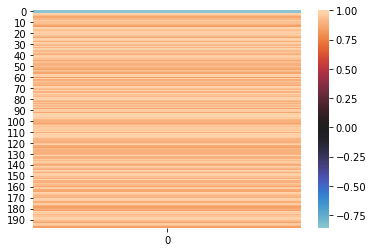

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 74
Task 0 hypothetical scores:


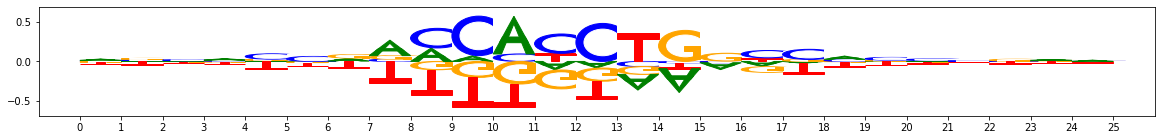

Task 0 actual importance scores:


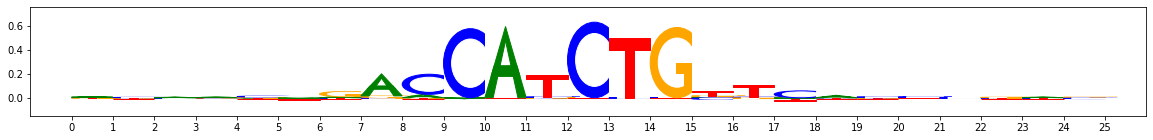

onehot, fwd and rev:


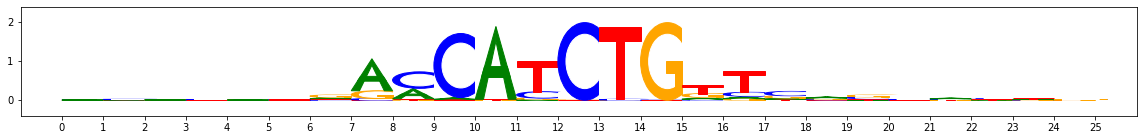

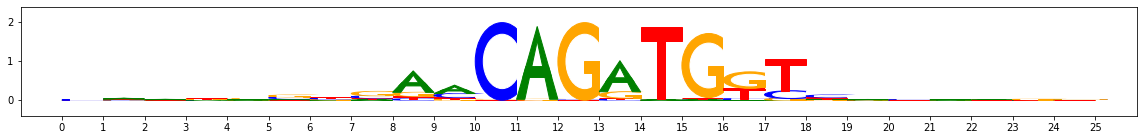

PLOTTING SUBCLUSTERS


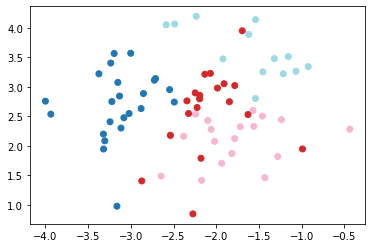

subcluster_0 size 23


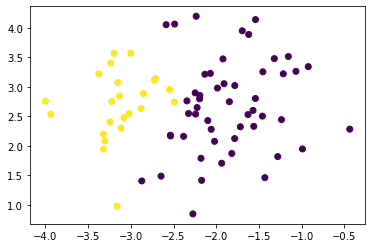

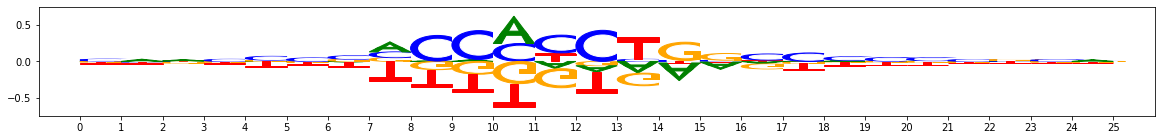

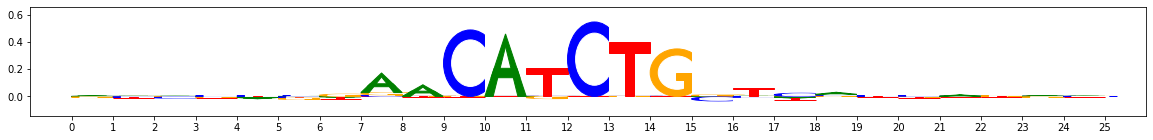

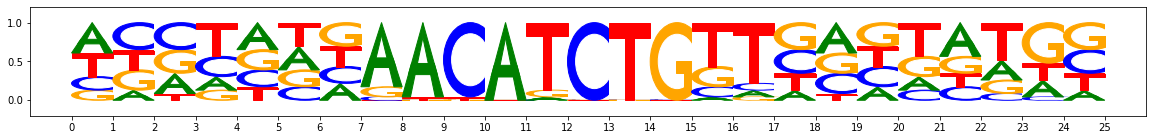

subcluster_2 size 19


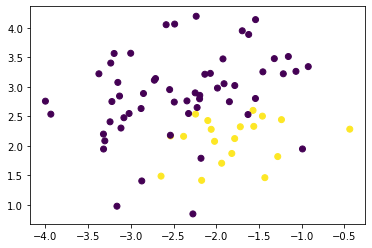

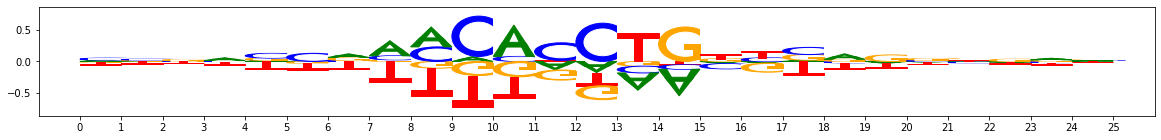

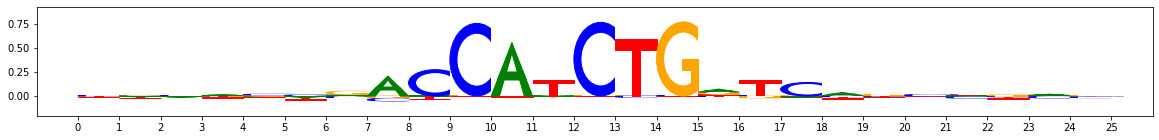

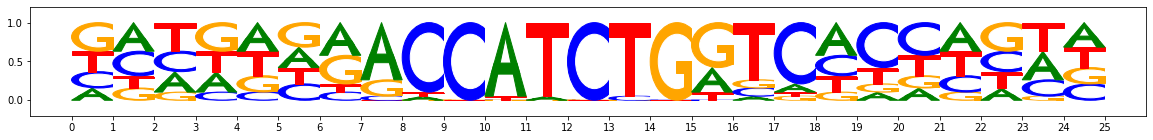

subcluster_1 size 19


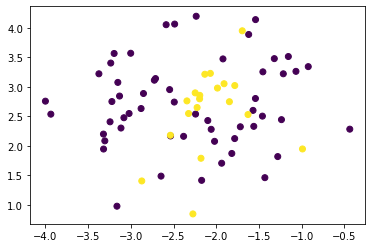

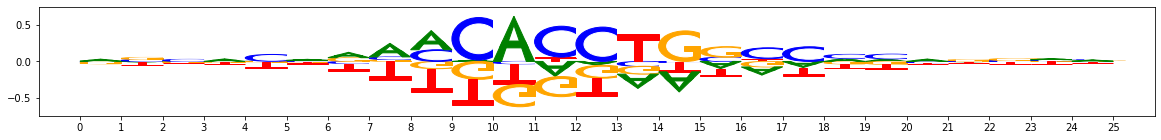

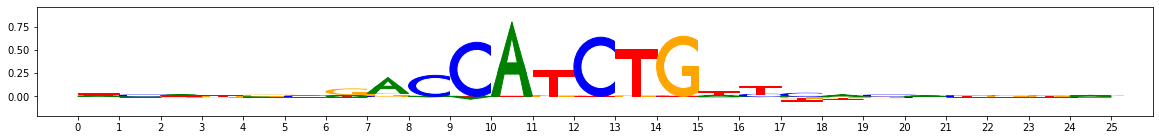

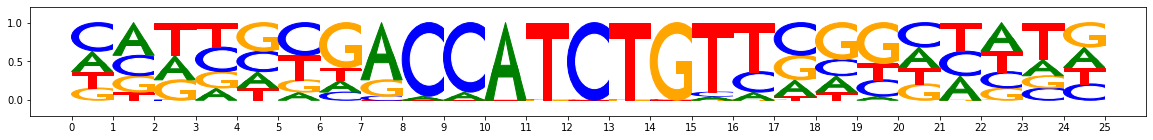

subcluster_3 size 13


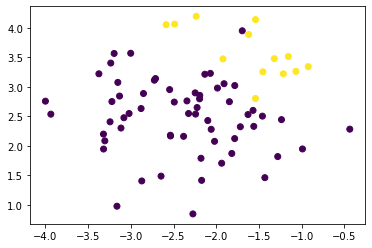

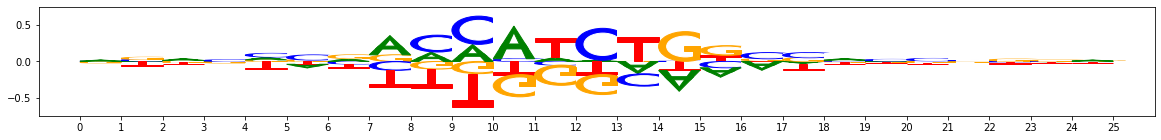

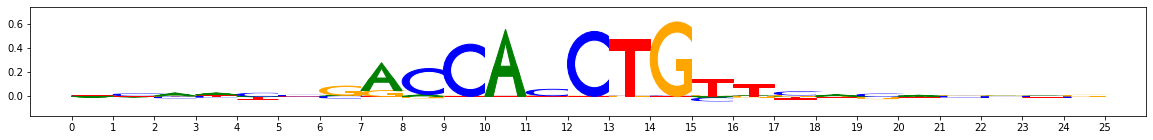

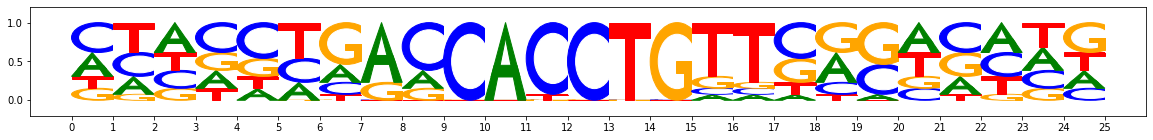

metacluster_0 pattern_1
total seqlets: 71
Task 0 hypothetical scores:


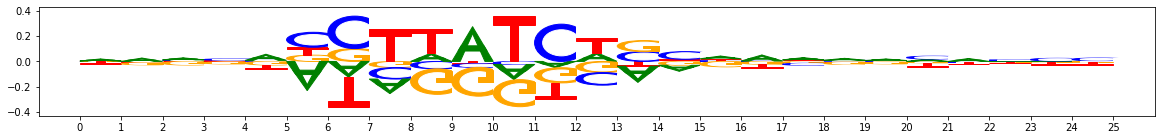

Task 0 actual importance scores:


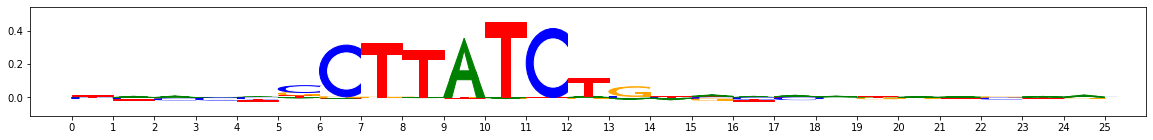

onehot, fwd and rev:


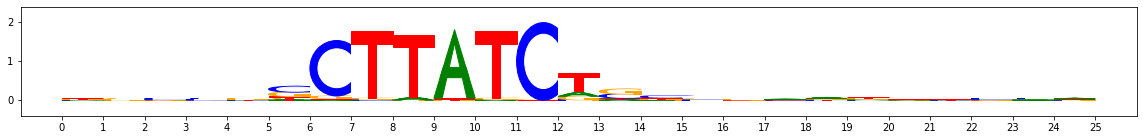

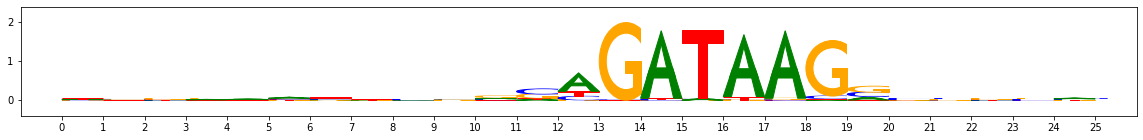

PLOTTING SUBCLUSTERS


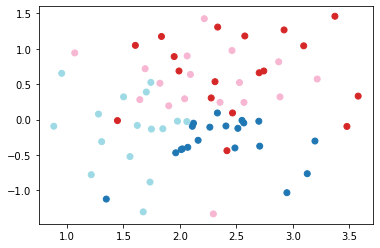

subcluster_0 size 20


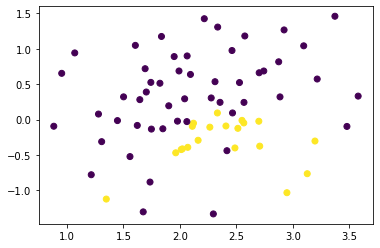

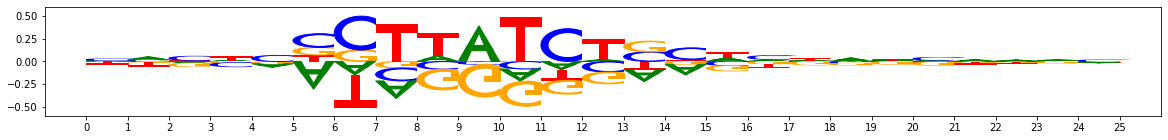

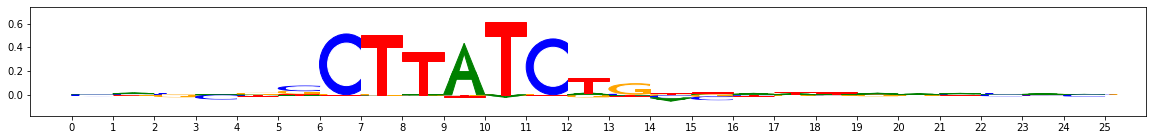

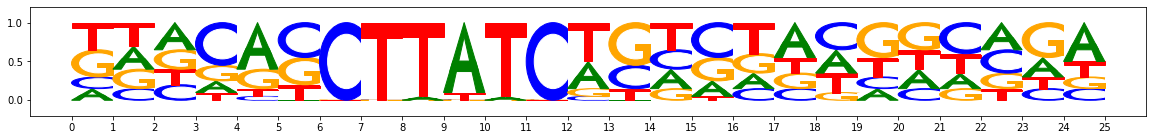

subcluster_1 size 18


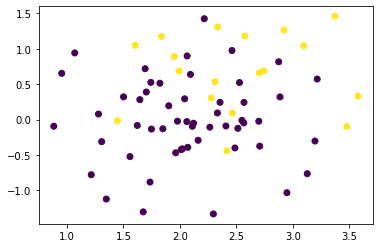

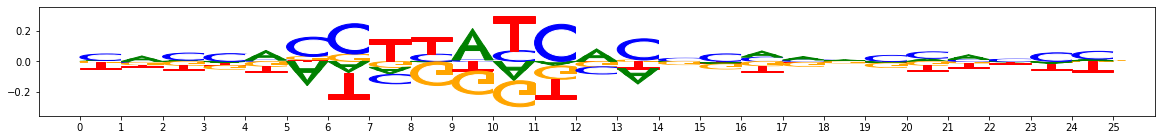

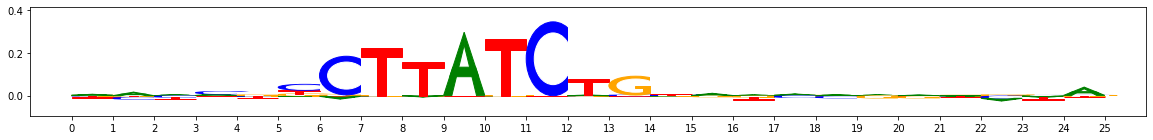

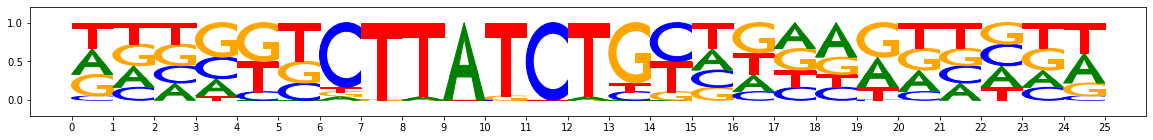

subcluster_2 size 17


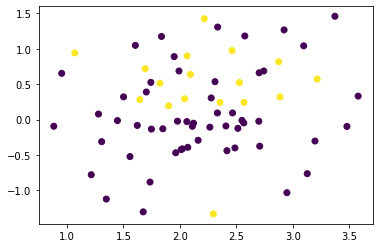

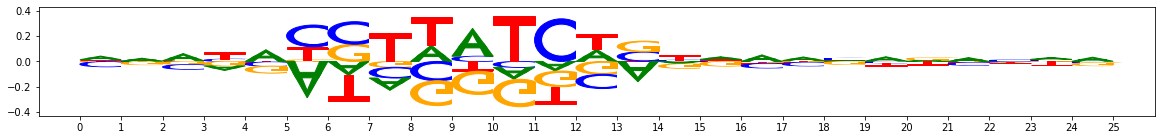

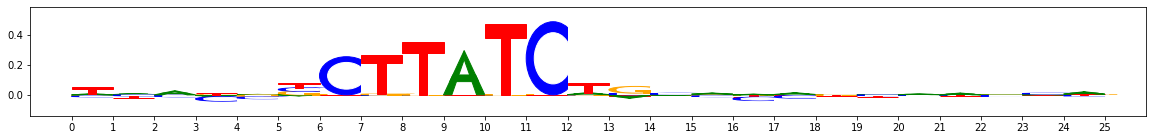

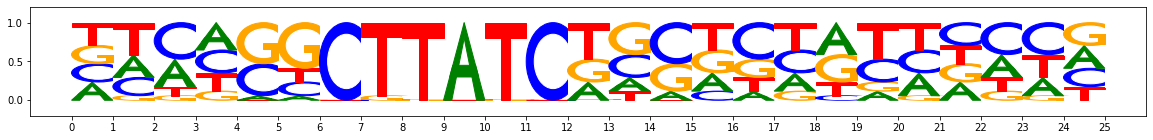

subcluster_3 size 16


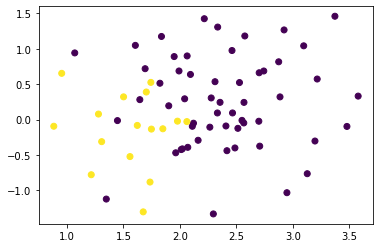

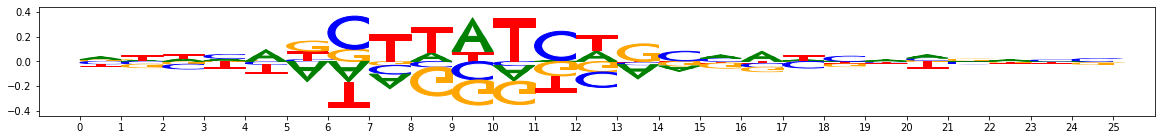

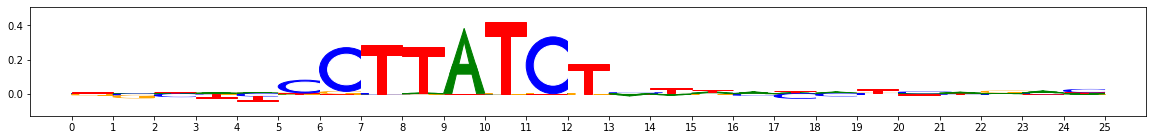

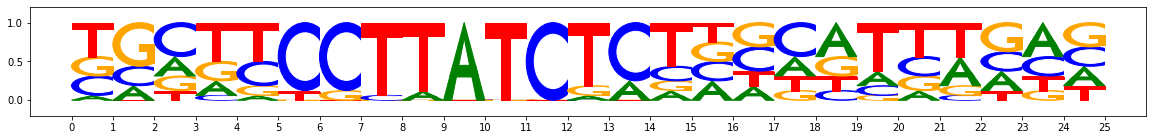

In [7]:
from collections import Counter
import numpy as np

from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.mean(onehot_data, axis=(0,1))

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        #print("Task 1 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        #print("Task 1 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        #print("Task 2 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        #print("Task 2 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        #Plot the subclustering too, if available
        if ("subclusters" in pattern):
            print("PLOTTING SUBCLUSTERS")
            subclusters = np.array(pattern["subclusters"])
            twod_embedding = np.array(pattern["twod_embedding"])
            plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=subclusters, cmap="tab20")
            plt.show()
            for subcluster_name in list(pattern["subcluster_to_subpattern"]["subcluster_names"]):
                subpattern = pattern["subcluster_to_subpattern"][subcluster_name]
                print(subcluster_name.decode("utf-8"), "size", len(subpattern["seqlets_and_alnmts"]["seqlets"]))
                subcluster = int(subcluster_name.decode("utf-8").split("_")[1])
                plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
                plt.show()
                viz_sequence.plot_weights(subpattern["task0_hypothetical_contribs"]["fwd"])
                viz_sequence.plot_weights(subpattern["task0_contrib_scores"]["fwd"])
                viz_sequence.plot_weights(subpattern["sequence"]["fwd"])
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [8]:
import h5py
import numpy as np
from importlib import reload
import modisco
reload(modisco.util)
reload(modisco.core)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

#If loading from a file for which subclusters haven't been computed (e.g. a file produced by an
# earlier version of modisco), you can compute the subclusters by
# following this template:
#patterns = (loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results["metacluster_0"]
#            .seqlets_to_patterns_result.patterns)
#for pattern in patterns:
#    pattern.compute_subclusters_and_embedding(
#                 pattern_comparison_settings=modisco.affinitymat.core.PatternComparisonSettings(                         
#                    track_names=["task0_hypothetical_contribs", "task0_contrib_scores"],                      
#                    track_transformer=modisco.affinitymat.L1Normalizer(),
#                    min_overlap=None), #min_overlap argument is irrelevant here    
#                 perplexity=30, n_jobs=4, verbose=True)

## Do hit scoring
The hit scoring strategy is still in development. For the previous hit scoring strategy, see the version at tag TODO

### Trim the motifs to fixed windows by information content

In [9]:
import modisco
import modisco.util
reload(modisco.util)
reload(modisco.cluster.core)
from modisco.visualization import viz_sequence
reload(modisco.aggregator)
from modisco import hit_scoring
reload(modisco.hit_scoring)
from modisco.hit_scoring import densityadapted_hitscoring
reload(modisco.hit_scoring.densityadapted_hitscoring)
reload(densityadapted_hitscoring)

n_cores = 4
min_overlap_size = 10 #want to have at least this many bp of overlap before scoring
onehot_track_name = "sequence"

target_seqlet_size = 25 #same as during seqlet identification
bg_freq = np.mean(onehot_data, axis=(0,1))

onehot_track_name = "sequence"
task_names = ["task0"]

orig_patterns = (loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results["metacluster_0"]
                .seqlets_to_patterns_result.patterns)

trimmed_subclustered_patterns = densityadapted_hitscoring.trim_and_subcluster_patterns(
     patterns=orig_patterns,
     window_size=target_seqlet_size,
     onehot_track_name=onehot_track_name,
     task_names=task_names,
     bg_freq=bg_freq,
     n_cores=n_cores)

orig_patterns = (loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_0"]
    .seqlets_to_patterns_result.patterns)

Trimming the patterns to the target length
Apply subclustering


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.6s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Computing 73 nearest neighbors...
[t-SNE] Indexed 74 samples in 0.001s...
[t-SNE] Computed neighbors for 74 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 74 / 74
[t-SNE] Mean sigma: 0.436397
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 51.8853607, gradient norm = 0.4637910 (50 iterations in 0.014s)
[t-SNE] Iteration 100: error = 50.1360016, gradient norm = 0.4128502 (50 iterations in 0.020s)
[t-SNE] Iteration 150: error = 52.9414558, gradient norm = 0.5017180 (50 iterations in 0.013s)
[t-SNE] Iteration 200: error = 52.0900345, gradient norm = 0.5453429 (50 iterations in 0.013s)
[t-SNE] Iteration 250: error = 52.8413086, gradient norm = 0.4979126 (50 iterations in 0.017s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.841309
[t-SNE] Iteration 300: error = 0.8926135, gradient norm = 0.0027051 (50 iterations in 0.013s)
[t-SNE] Iteration 350: error = 0.7730397, gradient norm = 0.0013956 (50 i

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s


Quality: 0.12744002336127436


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  71 out of  71 | elapsed:    0.0s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


Got subclusters: Counter({0: 23, 2: 19, 1: 19, 3: 13})
[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 71 samples in 0.001s...
[t-SNE] Computed neighbors for 71 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 71 / 71
[t-SNE] Mean sigma: 0.477791
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 52.3779373, gradient norm = 0.6054187 (50 iterations in 0.020s)
[t-SNE] Iteration 100: error = 51.1176834, gradient norm = 0.4875111 (50 iterations in 0.018s)
[t-SNE] Iteration 150: error = 48.8018532, gradient norm = 0.4449487 (50 iterations in 0.018s)
[t-SNE] Iteration 200: error = 52.1530380, gradient norm = 0.5447511 (50 iterations in 0.018s)
[t-SNE] Iteration 250: error = 50.9462967, gradient norm = 0.4620174 (50 iterations in 0.018s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.946297
[t-SNE] Iteration 300: error = 0.7157012, gradient norm = 0.0023502 (50 iterations in 0.017s)
[t-SNE] Iteration 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s


Quality: 0.08528066364798892
Quality: 0.09020102234331018
Got subclusters: Counter({0: 20, 1: 18, 2: 17, 3: 16})


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.9s finished


Original pattern


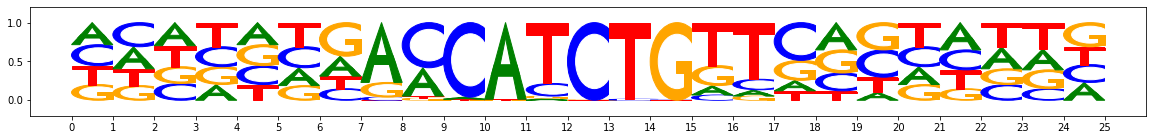

Trimmed pattern


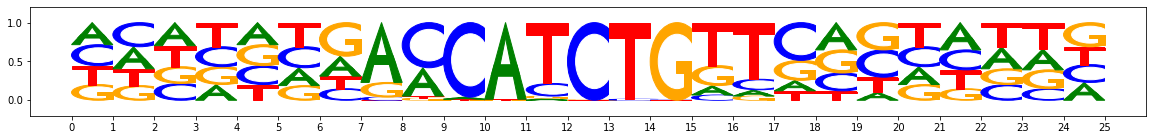

Original pattern


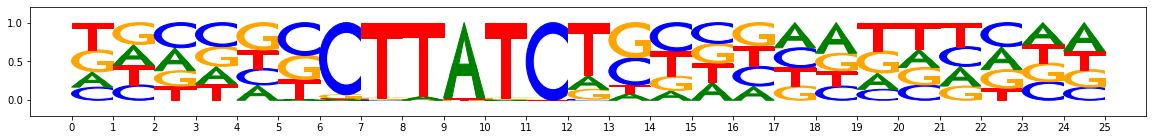

Trimmed pattern


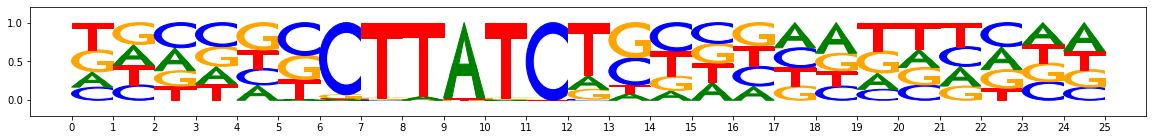

In [10]:
for orig_pattern,trimmed_pattern in zip(orig_patterns, trimmed_subclustered_patterns):
    print("Original pattern")
    viz_sequence.plot_weights(orig_pattern["sequence"].fwd)
    print("Trimmed pattern")
    viz_sequence.plot_weights(trimmed_pattern["sequence"].fwd)

In [29]:
import modisco.util
reload(modisco.util)
reload(modisco.cluster.core)
from modisco import hit_scoring
reload(modisco.hit_scoring)
from modisco.hit_scoring import densityadapted_hitscoring
reload(modisco.hit_scoring.densityadapted_hitscoring)
from modisco.hit_scoring import densityadapted_hitscoring
reload(modisco.seqlet_embedding.advanced_gapped_kmer)
reload(modisco.seqlet_embedding)

min_overlap_size = 10
seqlet_scorer = densityadapted_hitscoring.prepare_seqlet_scorer(
    patterns=trimmed_subclustered_patterns,
    onehot_track_name=onehot_track_name,
    task_names_and_signs=[(x,1) for x in task_names],
    n_cores=n_cores,
    max_seqlets_per_submotif=100,
    min_overlap_size=min_overlap_size)

Pattern length (and hence target seqlet size) is 25
Subsampling subpattern 0
Subsampling subpattern 1
Subsampling subpattern 2
Subsampling subpattern 5
Subsampling subpattern 6
Prepare seqlet scorer
Computing coarse-grained embeddings


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 920 out of 927 | elapsed:   27.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 927 out of 927 | elapsed:   27.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 920 out of 927 | elapsed:   27.3s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 927 out of 927 | elapsed:   27.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 927 out of 927 | elapsed:    2.1s finished


Constructing csr matrix...
csr matrix made in 0.22873902320861816 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 927 out of 927 | elapsed:    2.1s finished


Constructing csr matrix...
csr matrix made in 0.22162318229675293 s
Computing coarse top k nn via cosine sim
Batching in slices of size 927


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

Computing fine-grained sim for top k
Launching nearest neighbors affmat calculation job
MEMORY 1.639268352


Parallel runs completed
MEMORY 1.6438272
Job completed in: 9.69 s
MEMORY 1.6438272
Launching nearest neighbors affmat calculation job
MEMORY 1.6438272
Parallel runs completed
MEMORY 1.6438272
Job completed in: 9.42 s
MEMORY 1.6438272
Mapping affinity to distmat
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
Computing density-adapted nn affmat
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.4s


Quality: 0.0015275219245083431


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.3s


Quality: 0.3926301849115958
Quality: 0.39277005810732124


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   15.6s finished


Number of reclustered idxs: 4
{(1, 0), (2, 1), (3, 1), (0, 1)}
Preparing modularity scorer
Accuracy: 0.9978425026968716


In [30]:
#investigate mis-assigned seqlets
pattern0_classes, pattern0_precisions, pattern0_percentiles, pattern0_moddeltas = seqlet_scorer(trimmed_subclustered_patterns[0].seqlets)
pattern1_classes, pattern1_precisions, pattern1_percentiles, pattern1_moddeltas = seqlet_scorer(trimmed_subclustered_patterns[1].seqlets)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 586 out of 593 | elapsed:   17.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 593 out of 593 | elapsed:   17.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.13825201988220215 s
Batching in slices of size 593


[Parallel(n_jobs=1)]: Done 593 out of 593 | elapsed:    1.3s finished
100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

Launching nearest neighbors affmat calculation job
MEMORY 1.649078272


Parallel runs completed
MEMORY 1.649750016
Job completed in: 6.13 s
MEMORY 1.649750016
Launching nearest neighbors affmat calculation job
MEMORY 1.649750016
Parallel runs completed
MEMORY 1.649750016
Job completed in: 5.97 s
MEMORY 1.649750016


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 511 out of 518 | elapsed:   14.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 518 out of 518 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.11458086967468262 s
Batching in slices of size 518


[Parallel(n_jobs=1)]: Done 518 out of 518 | elapsed:    1.2s finished
100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

Launching nearest neighbors affmat calculation job
MEMORY 1.650778112


Parallel runs completed
MEMORY 1.650778112
Job completed in: 5.47 s
MEMORY 1.650778112
Launching nearest neighbors affmat calculation job
MEMORY 1.650778112
Parallel runs completed
MEMORY 1.650778112
Job completed in: 5.31 s
MEMORY 1.650778112


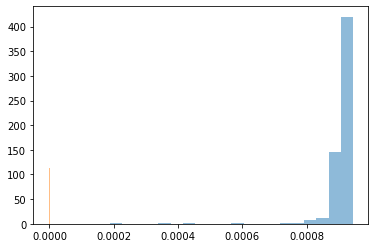

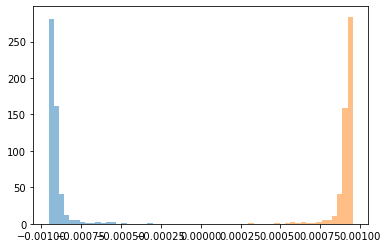

In [31]:
plt.hist(pattern0_moddeltas[:,0], bins=20, alpha=0.5)
plt.hist(pattern0_moddeltas[:,1], bins=20, alpha=0.5)
plt.show()
plt.hist(pattern1_moddeltas[:,0], bins=20, alpha=0.5)
plt.hist(pattern1_moddeltas[:,1], bins=20, alpha=0.5)
plt.show()

In [32]:
#visualize the mis-classified seqlets from the original patterns
print("Misclassified seqlets from pattern 0")
pattern0_seqlets = trimmed_subclustered_patterns[0].seqlets
for misclassified_pattern0_idx in np.nonzero(pattern0_classes==1)[0]:
    print("precision:",pattern0_precisions[misclassified_pattern0_idx])
    print("percentile:",pattern0_percentiles[misclassified_pattern0_idx])
    print("modularitydeltas:",pattern0_moddeltas[misclassified_pattern0_idx])
    viz_sequence.plot_weights(pattern0_seqlets[misclassified_pattern0_idx]["task0_contrib_scores"].fwd)

print("Misclassified seqlets from pattern 1")
pattern1_seqlets = trimmed_subclustered_patterns[1].seqlets
for misclassified_pattern1_idx in np.nonzero(pattern1_classes==0)[0]:
    print("precision:",pattern1_precisions[misclassified_pattern1_idx])
    print("percentile:",pattern1_percentiles[misclassified_pattern1_idx])
    print("modularitydeltas:",pattern1_moddeltas[misclassified_pattern1_idx])
    viz_sequence.plot_weights(pattern1_seqlets[misclassified_pattern1_idx]["task0_contrib_scores"].fwd)

Misclassified seqlets from pattern 0
Misclassified seqlets from pattern 1


Fitting - on window size 7
peak(mu)= -0.004282484851777554
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.40826467476677464 occurring at 1.475214958190918e-06 implying a frac_neg of 0.6899447394083867
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.0 occurring at -1.3776182227951544e-05 implying a frac_neg of 1.00000010000001e-07
To be conservative, adjusted frac neg is 0.95


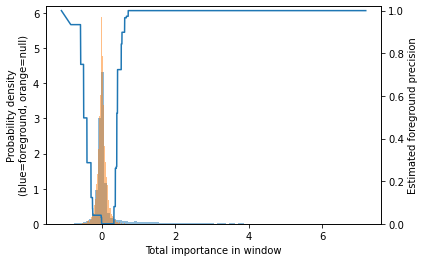

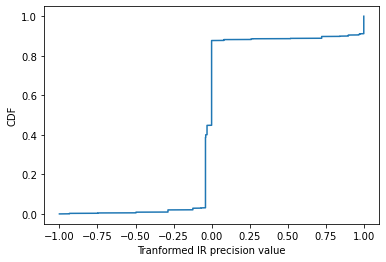

Thresholds from null dist were -0.8  and  0.8 with frac passing 0.10525
Got 353 coords


In [11]:
#Use a CoordProducer object to get candidate seqlet coordintes

#The reason I am not using the original CoordProducer settings from the initial
# tf-modisco run is that at the stage of hit-scoring, you may want to have more sensitivity,
# and that would lead to different ideal settings as compared to the original run.
#We will also use VariableWindowAroundChunks even though we specify a single window size
# as this coordproducer is set up to score based on precision w.r.t. a. null
reload(modisco.coordproducers)
import numpy as np

core_sliding_window = 7 #on the shorter side, for sensitivity
assert (target_seqlet_size-core_sliding_window)%2 == 0 #need even flanks on either side
coordproducer = modisco.coordproducers.VariableWindowAroundChunks(
    sliding=[core_sliding_window], #the core sliding window size to use
    flank=int((target_seqlet_size-core_sliding_window)/2.0),
    #suppress = how many windows on either side of the core window to suppress.
    #suppress=core_sliding_window_size means that additional sliding windows that overlap
    # the core are not allowed
    suppress=core_sliding_window,
    target_fdr=0.2,
    min_passing_windows_frac=0.03,
    max_passing_windows_frac=0.2,      
    separate_pos_neg_thresholds=False,                             
    max_seqlets_total=np.inf)
coordproducer_results = coordproducer(score_track=np.sum(task_to_scores["task0"], axis=-1),
                       #can also supply an empirical null distribution
                       null_track=modisco.coordproducers.LaplaceNullDist(num_to_samp=10000)
                      )



In [15]:
coordproducer_results.tnt_results

In [34]:
#fetch seqlets associated with the coordinates
seqlets = track_set.create_seqlets(coordproducer_results.coords)
#get the precision values associated with each seqlet
value_provider = modisco.value_provider.TransformCentralWindowValueProvider(
                    track_name="task0_contrib_scores",
                    central_window=[core_sliding_window],
                    val_transformer=coordproducer_results.tnt_results.val_transformer)
seqlet_irprecision = [value_provider(x) for x in seqlets]
pos_seqlets, pos_seqlets_irprecisions = list(
    zip(*[x for x in zip(seqlets, seqlet_irprecision) if x[1] > 0]))

In [35]:
print("Number of pos seqlets:",len(pos_seqlets))

Number of pos seqlets: 2707


In [36]:
#Score these seqlets
#posseqlet_classes = the pattern idx that got mapped to
(posseqlet_classes, posseqlet_precisions, posseqlet_percentiles, seqlet_moddeltas) =\
    seqlet_scorer(pos_seqlets)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   46.4s
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 2707 out of 2707 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2707 out of 2707 | elapsed:    7.1s finished


Constructing csr matrix...
csr matrix made in 0.650975227355957 s
Batching in slices of size 2707


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Launching nearest neighbors affmat calculation job
MEMORY 1.750695936
Parallel runs completed
MEMORY 1.751261184
Job completed in: 30.34 s
MEMORY 1.751261184
Launching nearest neighbors affmat calculation job
MEMORY 1.751261184
Parallel runs completed
MEMORY 1.751261184
Job completed in: 36.03 s
MEMORY 1.751261184


In [37]:
#For each seqlet, get the alignment for the class that it maps to
from collections import defaultdict
from collections import namedtuple

MotifMatch = namedtuple("MotifMatch", ["patternidx", "exampleidx", "start", "end", "is_revcomp",
                                       "crosscontin_sim", "modularity_precision",
                                       "modularity_percentile"])

pattern_aligner = modisco.core.CrossContinJaccardPatternAligner(              
    pattern_comparison_settings=
        modisco.affinitymat.core.PatternComparisonSettings(                         
                track_names=["task0_hypothetical_contribs", "task0_contrib_scores"],                      
                track_transformer=modisco.affinitymat.L1Normalizer(),
                min_overlap=float(min_overlap_size)/target_seqlet_size))

motifmatches = []
for seqletidx,(seqlet, patternidx) in enumerate(zip(pos_seqlets, posseqlet_classes)):
    assert seqlet.coor.is_revcomp==False
    mappedtomotif = trimmed_subclustered_patterns[patternidx]
    alignment, rc, sim = pattern_aligner(parent_pattern=seqlet,
                                         child_pattern=mappedtomotif)
    motifmatch = MotifMatch(patternidx=patternidx,
                   exampleidx=seqlet.coor.example_idx,
                   start=seqlet.coor.start+alignment,
                   end=seqlet.coor.start+alignment+len(mappedtomotif),
                   is_revcomp=rc,
                   crosscontin_sim=sim,
                   modularity_precision=posseqlet_precisions[seqletidx],
                   modularity_percentile=posseqlet_percentiles[seqletidx])
    motifmatches.append(motifmatch)
    
#Remove duplicate motif matches that can occur due to overlapping seqlets
unique_motifmatches = []
motifmatches_set = set()
patternidx_to_matches = defaultdict(list)
exampleidx_to_matches = defaultdict(list)
duplicates_found = 0
for motifmatch in motifmatches:
    match_identifier = (motifmatch.patternidx, motifmatch.exampleidx, motifmatch.start,
                        motifmatch.end, motifmatch.is_revcomp)
    if match_identifier not in motifmatches_set:
        unique_motifmatches.append(motifmatch)
        patternidx_to_matches[motifmatch.patternidx].append(motifmatch)
        exampleidx_to_matches[motifmatch.exampleidx].append(motifmatch)
    else:
        duplicates_found += 1
    motifmatches_set.add(match_identifier)
print("Removed",duplicates_found,"duplicates")

Removed 1085 duplicates


MotifMatch(patternidx=0, exampleidx=0, start=118, end=143, is_revcomp=True, crosscontin_sim=0.4662270420987023, modularity_precision=1.0, modularity_percentile=0.4832214765100671)
MotifMatch(patternidx=1, exampleidx=0, start=146, end=171, is_revcomp=True, crosscontin_sim=0.5830895184818444, modularity_precision=1.0, modularity_percentile=0.76875)
MotifMatch(patternidx=0, exampleidx=0, start=161, end=186, is_revcomp=True, crosscontin_sim=0.4807730262807218, modularity_precision=1.0, modularity_percentile=0.2505592841163311)


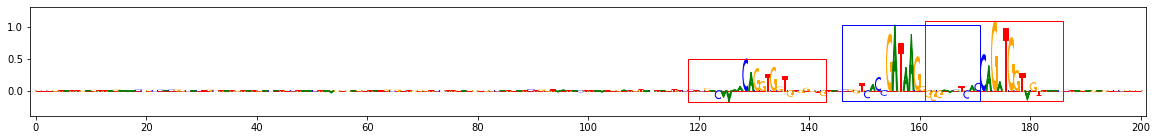

MotifMatch(patternidx=1, exampleidx=1, start=62, end=87, is_revcomp=False, crosscontin_sim=0.3922114748897995, modularity_precision=1.0, modularity_percentile=0.40625)
MotifMatch(patternidx=1, exampleidx=1, start=86, end=111, is_revcomp=False, crosscontin_sim=0.3494087773755443, modularity_precision=1.0, modularity_percentile=0.41666666666666663)
MotifMatch(patternidx=1, exampleidx=1, start=153, end=178, is_revcomp=False, crosscontin_sim=0.31418381996679967, modularity_precision=1.0, modularity_percentile=0.3104166666666667)


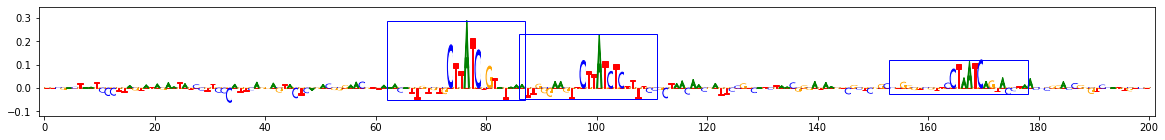

MotifMatch(patternidx=0, exampleidx=2, start=5, end=30, is_revcomp=True, crosscontin_sim=0.3784124427234995, modularity_precision=1.0, modularity_percentile=0.18568232662192397)
MotifMatch(patternidx=0, exampleidx=2, start=62, end=87, is_revcomp=True, crosscontin_sim=0.5588350824060374, modularity_precision=1.0, modularity_percentile=0.21700223713646527)
MotifMatch(patternidx=0, exampleidx=2, start=144, end=169, is_revcomp=True, crosscontin_sim=0.5045724996666066, modularity_precision=1.0, modularity_percentile=0.29977628635346754)


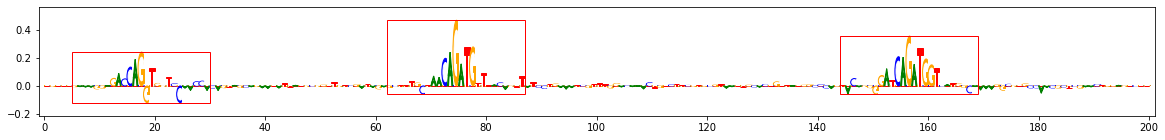

MotifMatch(patternidx=1, exampleidx=3, start=63, end=88, is_revcomp=False, crosscontin_sim=0.6069880214216173, modularity_precision=1.0, modularity_percentile=0.9229166666666666)
MotifMatch(patternidx=0, exampleidx=3, start=96, end=121, is_revcomp=False, crosscontin_sim=0.5889893600595778, modularity_precision=1.0, modularity_percentile=0.4586129753914989)
MotifMatch(patternidx=0, exampleidx=3, start=127, end=152, is_revcomp=False, crosscontin_sim=0.6013246642870961, modularity_precision=1.0, modularity_percentile=0.8076062639821029)
MotifMatch(patternidx=0, exampleidx=3, start=163, end=188, is_revcomp=False, crosscontin_sim=0.5368369396945177, modularity_precision=1.0, modularity_percentile=0.4071588366890381)
MotifMatch(patternidx=1, exampleidx=3, start=19, end=44, is_revcomp=False, crosscontin_sim=0.30904457585006206, modularity_precision=1.0, modularity_percentile=0.31875)


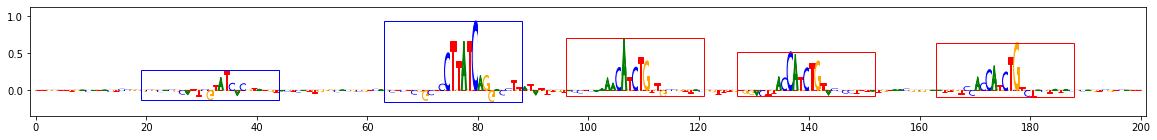

MotifMatch(patternidx=1, exampleidx=6, start=166, end=191, is_revcomp=True, crosscontin_sim=0.25152020431954636, modularity_precision=1.0, modularity_percentile=0.20625000000000004)


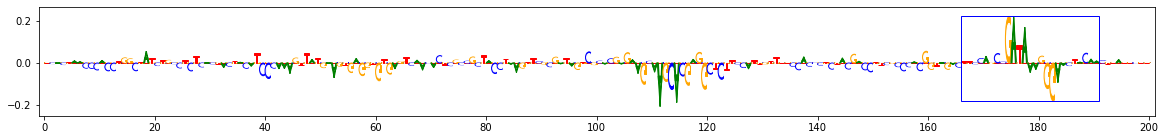

MotifMatch(patternidx=1, exampleidx=8, start=22, end=47, is_revcomp=False, crosscontin_sim=0.41005445626940284, modularity_precision=1.0, modularity_percentile=0.7083333333333333)
MotifMatch(patternidx=1, exampleidx=8, start=84, end=109, is_revcomp=False, crosscontin_sim=0.45212452088686694, modularity_precision=1.0, modularity_percentile=0.7375)
MotifMatch(patternidx=1, exampleidx=8, start=130, end=155, is_revcomp=False, crosscontin_sim=0.3666665668740373, modularity_precision=1.0, modularity_percentile=0.51875)


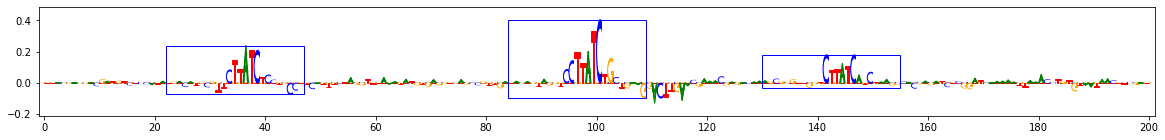

MotifMatch(patternidx=1, exampleidx=9, start=22, end=47, is_revcomp=False, crosscontin_sim=0.5943264628399428, modularity_precision=1.0, modularity_percentile=0.7083333333333333)
MotifMatch(patternidx=0, exampleidx=9, start=80, end=105, is_revcomp=False, crosscontin_sim=0.5931946801224904, modularity_precision=1.0, modularity_percentile=0.7225950782997763)
MotifMatch(patternidx=1, exampleidx=9, start=160, end=185, is_revcomp=False, crosscontin_sim=0.5940799037146166, modularity_precision=1.0, modularity_percentile=0.7958333333333334)


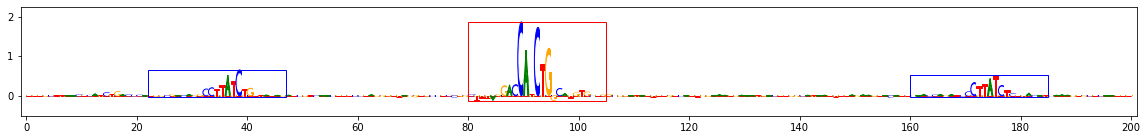

MotifMatch(patternidx=1, exampleidx=10, start=129, end=154, is_revcomp=True, crosscontin_sim=0.5051926608553572, modularity_precision=1.0, modularity_percentile=0.7729166666666667)


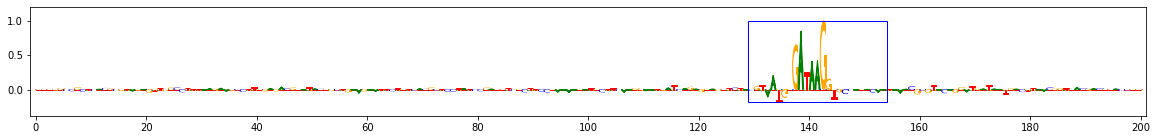

MotifMatch(patternidx=0, exampleidx=11, start=46, end=71, is_revcomp=False, crosscontin_sim=0.614836017342355, modularity_precision=1.0, modularity_percentile=0.6733780760626398)
MotifMatch(patternidx=1, exampleidx=11, start=93, end=118, is_revcomp=False, crosscontin_sim=0.4437365844624613, modularity_precision=1.0, modularity_percentile=0.2520833333333333)


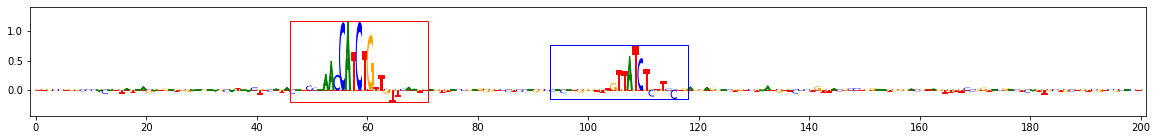

MotifMatch(patternidx=0, exampleidx=12, start=93, end=118, is_revcomp=False, crosscontin_sim=0.6046431656699104, modularity_precision=1.0, modularity_percentile=0.70917225950783)
MotifMatch(patternidx=1, exampleidx=12, start=126, end=151, is_revcomp=False, crosscontin_sim=0.5768959521640417, modularity_precision=1.0, modularity_percentile=0.9958333333333333)
MotifMatch(patternidx=1, exampleidx=12, start=171, end=196, is_revcomp=False, crosscontin_sim=0.5873318051200633, modularity_precision=1.0, modularity_percentile=0.8041666666666667)


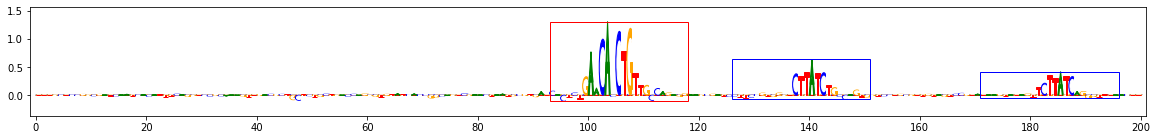

MotifMatch(patternidx=0, exampleidx=13, start=5, end=30, is_revcomp=False, crosscontin_sim=0.515928773505289, modularity_precision=1.0, modularity_percentile=0.2639821029082774)
MotifMatch(patternidx=1, exampleidx=13, start=173, end=198, is_revcomp=False, crosscontin_sim=0.5226725859671469, modularity_precision=1.0, modularity_percentile=0.53125)


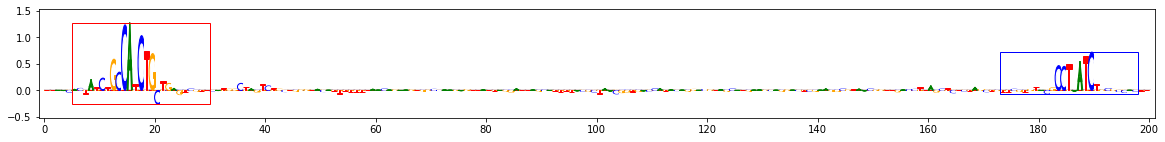

MotifMatch(patternidx=1, exampleidx=14, start=43, end=68, is_revcomp=True, crosscontin_sim=0.36032901220778946, modularity_precision=1.0, modularity_percentile=0.4395833333333333)


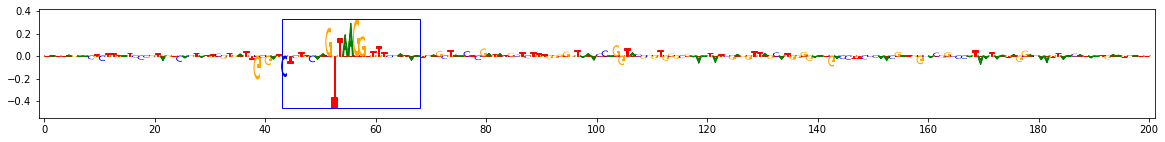

MotifMatch(patternidx=1, exampleidx=15, start=109, end=134, is_revcomp=False, crosscontin_sim=0.5596304514451879, modularity_precision=1.0, modularity_percentile=0.8729166666666667)
MotifMatch(patternidx=0, exampleidx=15, start=166, end=191, is_revcomp=False, crosscontin_sim=0.6418368845944464, modularity_precision=1.0, modularity_percentile=0.4272930648769575)


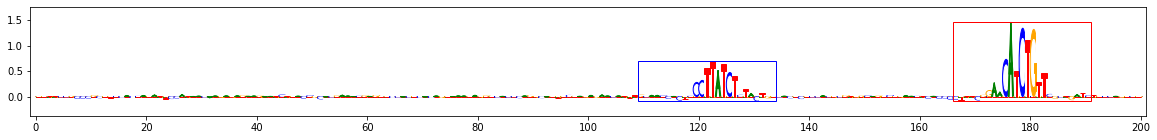

MotifMatch(patternidx=0, exampleidx=16, start=29, end=54, is_revcomp=False, crosscontin_sim=0.17382849947793627, modularity_precision=1.0, modularity_percentile=0.05145413870246085)
MotifMatch(patternidx=1, exampleidx=16, start=39, end=64, is_revcomp=False, crosscontin_sim=0.2841622035361328, modularity_precision=1.0, modularity_percentile=0.36250000000000004)
MotifMatch(patternidx=1, exampleidx=16, start=87, end=112, is_revcomp=False, crosscontin_sim=0.47494302594600507, modularity_precision=1.0, modularity_percentile=0.7270833333333333)


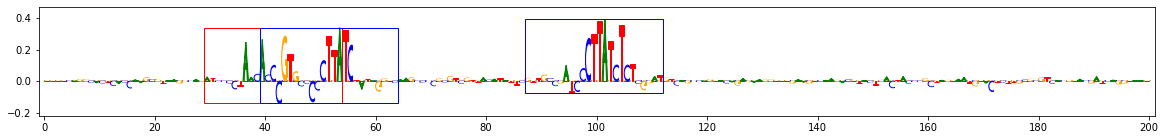

MotifMatch(patternidx=1, exampleidx=17, start=17, end=42, is_revcomp=True, crosscontin_sim=0.3739195628709632, modularity_precision=1.0, modularity_percentile=0.18958333333333333)
MotifMatch(patternidx=0, exampleidx=17, start=55, end=80, is_revcomp=True, crosscontin_sim=0.47550642096232876, modularity_precision=1.0, modularity_percentile=0.18568232662192397)


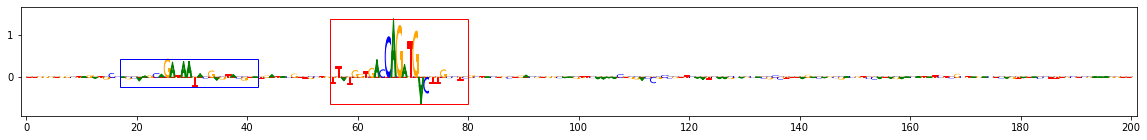

MotifMatch(patternidx=1, exampleidx=18, start=99, end=124, is_revcomp=False, crosscontin_sim=0.6402618594532204, modularity_precision=1.0, modularity_percentile=0.9)
MotifMatch(patternidx=0, exampleidx=18, start=116, end=141, is_revcomp=False, crosscontin_sim=0.4749150640147577, modularity_precision=1.0, modularity_percentile=0.2192393736017897)


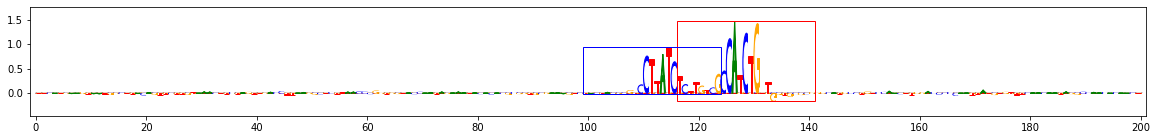

MotifMatch(patternidx=1, exampleidx=19, start=18, end=43, is_revcomp=False, crosscontin_sim=0.44308465996470886, modularity_precision=1.0, modularity_percentile=0.6666666666666667)
MotifMatch(patternidx=0, exampleidx=19, start=143, end=168, is_revcomp=False, crosscontin_sim=0.3202956849353634, modularity_precision=1.0, modularity_percentile=0.02684563758389258)
MotifMatch(patternidx=1, exampleidx=19, start=144, end=169, is_revcomp=True, crosscontin_sim=0.16255376620703993, modularity_precision=1.0, modularity_percentile=0.1166666666666667)


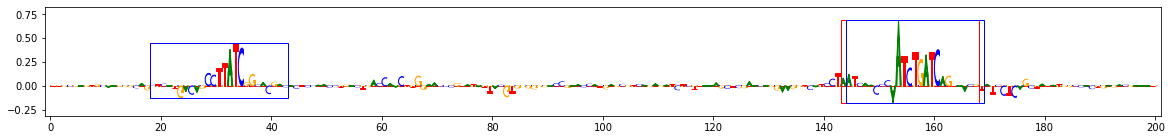

MotifMatch(patternidx=1, exampleidx=20, start=20, end=45, is_revcomp=True, crosscontin_sim=0.5729091288637227, modularity_precision=1.0, modularity_percentile=0.5979166666666667)


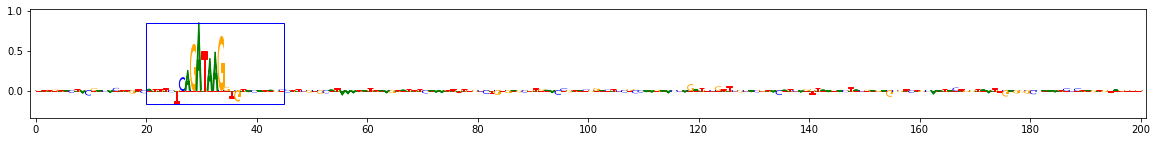

MotifMatch(patternidx=0, exampleidx=21, start=15, end=40, is_revcomp=False, crosscontin_sim=0.5294861060028188, modularity_precision=1.0, modularity_percentile=0.4138702460850112)
MotifMatch(patternidx=1, exampleidx=21, start=51, end=76, is_revcomp=False, crosscontin_sim=0.5839955025019472, modularity_precision=1.0, modularity_percentile=0.8479166666666667)
MotifMatch(patternidx=0, exampleidx=21, start=92, end=117, is_revcomp=False, crosscontin_sim=0.628094267263156, modularity_precision=1.0, modularity_percentile=0.27069351230425054)
MotifMatch(patternidx=1, exampleidx=21, start=125, end=150, is_revcomp=False, crosscontin_sim=0.4673831227578486, modularity_precision=1.0, modularity_percentile=0.5979166666666667)
MotifMatch(patternidx=1, exampleidx=21, start=169, end=194, is_revcomp=False, crosscontin_sim=0.5762440249434124, modularity_precision=1.0, modularity_percentile=0.93125)


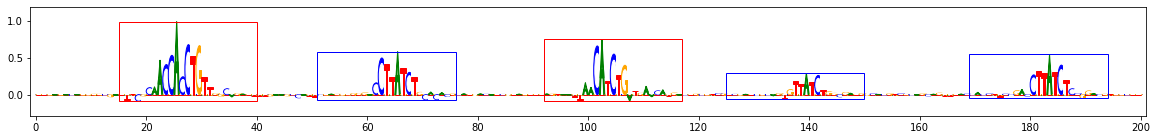

MotifMatch(patternidx=0, exampleidx=23, start=104, end=129, is_revcomp=True, crosscontin_sim=0.4877644953243742, modularity_precision=1.0, modularity_percentile=0.534675615212528)
MotifMatch(patternidx=0, exampleidx=23, start=121, end=146, is_revcomp=True, crosscontin_sim=0.500849546287003, modularity_precision=1.0, modularity_percentile=0.5234899328859061)
MotifMatch(patternidx=0, exampleidx=23, start=21, end=46, is_revcomp=True, crosscontin_sim=0.3889245267560635, modularity_precision=1.0, modularity_percentile=0.1633109619686801)


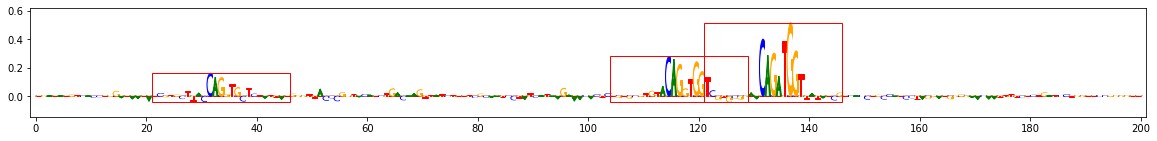

MotifMatch(patternidx=1, exampleidx=24, start=30, end=55, is_revcomp=False, crosscontin_sim=0.42833990031293145, modularity_precision=1.0, modularity_percentile=0.6791666666666667)
MotifMatch(patternidx=1, exampleidx=24, start=122, end=147, is_revcomp=False, crosscontin_sim=0.4511710607205106, modularity_precision=1.0, modularity_percentile=0.6666666666666667)


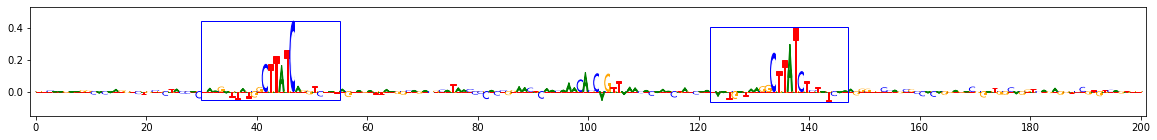

MotifMatch(patternidx=0, exampleidx=25, start=12, end=37, is_revcomp=False, crosscontin_sim=0.45099804824701367, modularity_precision=1.0, modularity_percentile=0.22818791946308725)
MotifMatch(patternidx=0, exampleidx=25, start=62, end=87, is_revcomp=False, crosscontin_sim=0.6212908585233933, modularity_precision=1.0, modularity_percentile=0.854586129753915)
MotifMatch(patternidx=0, exampleidx=25, start=128, end=153, is_revcomp=False, crosscontin_sim=0.43340351444404934, modularity_precision=1.0, modularity_percentile=0.20357941834451898)


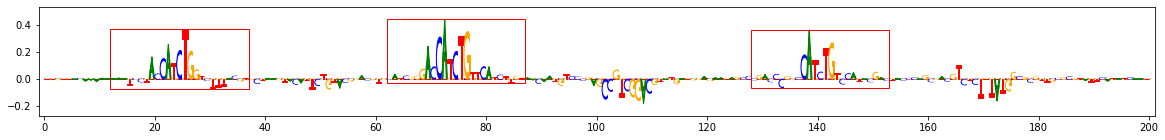

MotifMatch(patternidx=1, exampleidx=27, start=56, end=81, is_revcomp=False, crosscontin_sim=0.2803442090677729, modularity_precision=1.0, modularity_percentile=0.3458333333333333)


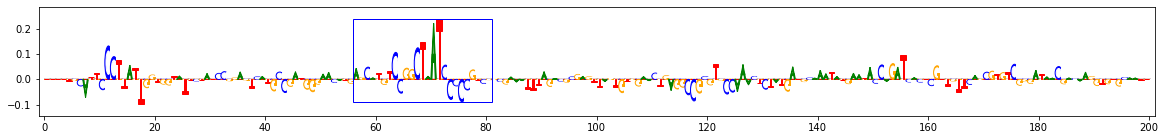

MotifMatch(patternidx=0, exampleidx=28, start=12, end=37, is_revcomp=True, crosscontin_sim=0.5421688110395199, modularity_precision=1.0, modularity_percentile=0.20134228187919467)
MotifMatch(patternidx=0, exampleidx=28, start=150, end=175, is_revcomp=True, crosscontin_sim=0.5413159516747941, modularity_precision=1.0, modularity_percentile=0.31991051454138697)
MotifMatch(patternidx=0, exampleidx=28, start=177, end=202, is_revcomp=True, crosscontin_sim=0.4676707941237418, modularity_precision=1.0, modularity_percentile=0.3042505592841164)


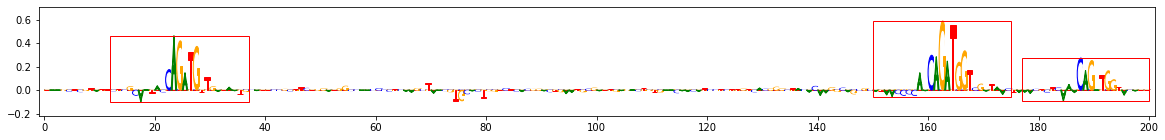

MotifMatch(patternidx=1, exampleidx=29, start=52, end=77, is_revcomp=False, crosscontin_sim=0.49160201530348774, modularity_precision=1.0, modularity_percentile=0.7666666666666666)
MotifMatch(patternidx=0, exampleidx=29, start=160, end=185, is_revcomp=False, crosscontin_sim=0.5738698134665453, modularity_precision=1.0, modularity_percentile=0.6599552572706935)


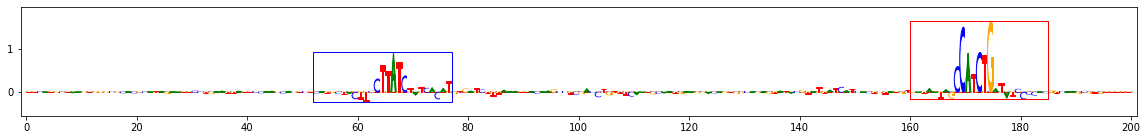

MotifMatch(patternidx=0, exampleidx=30, start=65, end=90, is_revcomp=False, crosscontin_sim=0.4403713864356584, modularity_precision=1.0, modularity_percentile=0.19910514541387025)
MotifMatch(patternidx=0, exampleidx=30, start=73, end=98, is_revcomp=False, crosscontin_sim=0.15143602343857726, modularity_precision=1.0, modularity_percentile=0.006711409395973145)


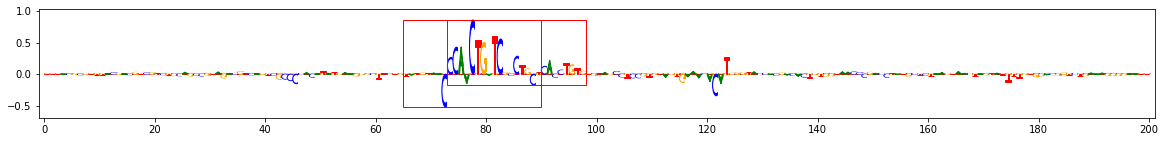

MotifMatch(patternidx=0, exampleidx=31, start=14, end=39, is_revcomp=True, crosscontin_sim=0.6439328703548284, modularity_precision=1.0, modularity_percentile=0.33109619686800895)
MotifMatch(patternidx=0, exampleidx=31, start=133, end=158, is_revcomp=True, crosscontin_sim=0.4655486048282882, modularity_precision=1.0, modularity_percentile=0.21252796420581654)


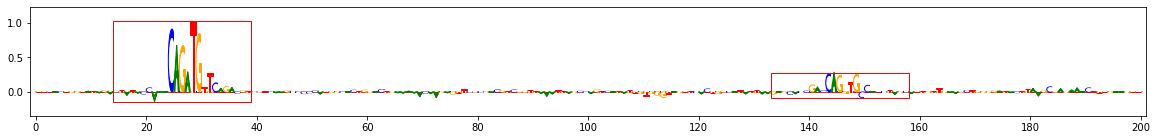

MotifMatch(patternidx=0, exampleidx=32, start=98, end=123, is_revcomp=False, crosscontin_sim=0.43925014800207923, modularity_precision=1.0, modularity_percentile=0.0738255033557047)


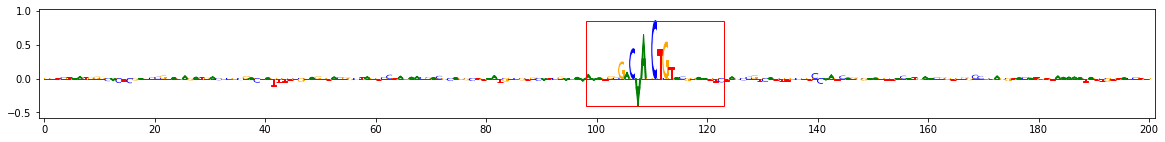

MotifMatch(patternidx=0, exampleidx=33, start=60, end=85, is_revcomp=True, crosscontin_sim=0.47649517755814275, modularity_precision=1.0, modularity_percentile=0.1901565995525727)
MotifMatch(patternidx=0, exampleidx=33, start=101, end=126, is_revcomp=True, crosscontin_sim=0.40027449118769676, modularity_precision=1.0, modularity_percentile=0.21029082774049213)
MotifMatch(patternidx=0, exampleidx=33, start=170, end=195, is_revcomp=True, crosscontin_sim=0.515738787486772, modularity_precision=1.0, modularity_percentile=0.19910514541387025)


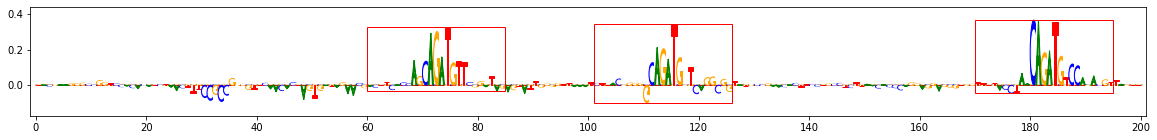

MotifMatch(patternidx=0, exampleidx=34, start=93, end=118, is_revcomp=False, crosscontin_sim=0.6041407059963799, modularity_precision=1.0, modularity_percentile=0.6487695749440716)


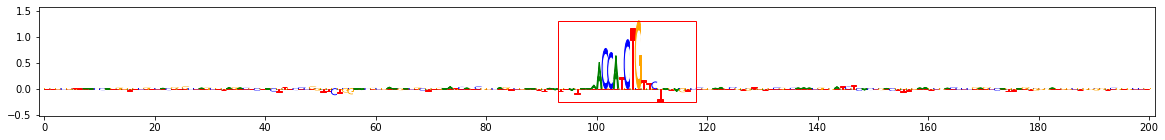

In [38]:
from modisco.visualization import viz_sequence

#visualize the matches
for exampleidx in list(sorted(exampleidx_to_matches.keys()))[:30]:
    matches = exampleidx_to_matches[exampleidx]
    for match in matches:
        print(match)
    
    viz_sequence.plot_weights(
        task_to_scores["task0"][exampleidx],
        highlight={'red': [
            (max(x.start,0), min(x.end,len(task_to_scores["task0"][exampleidx])))
             for x in matches if x.patternidx==0],
                   'blue': [
            (max(x.start,0), min(x.end,len(task_to_scores["task0"][exampleidx])) )
             for x in matches if x.patternidx==1]},
        subticks_frequency=20)

In [39]:
len(patternidx_to_matches[1])

785

## Inspect the pattern merging hierarchy

Inspect the hierarchy of motif merging events that led to the final motif. Read "Path to node" like a directory structure; all motifs at a similar level in the hierarchy (except for the topmost level) were collapsed together. Any motifs at the topmost level for which the number of seqlets was less than `final_min_cluster_size` were disbanded, and their seqlets were reassigned to the dominant motifs (provided the similarity passed a threshold)

In [ ]:
def recursive_plot_hierarchy_motifs(nodes, path):
    for i in range(len(nodes)):
        nodepath = path+"/"+str(i)
        print("Path to node:",nodepath)
        print("Number of seqlets",len(nodes[i].pattern.seqlets))
        if (nodes[i].indices_merged is not None):
            #indices_merged, submat_crosscontam and submat_alignersim can
            # be used to inspect the steps in the merging
            #print("indices merged:",nodes[i].indices_merged)
            #print("submat crosscontam:\n",nodes[i].submat_crosscontam)
            #print("submat alignersim:\n",nodes[i].submat_alignersim)
            pass
        
        #For plotting figures to a png, this code can be used...
        #fig = plt.figure(figsize=(20,5))                                           
        #ax = fig.add_subplot(111)
        #viz_sequence.plot_weights_given_ax(ax, nodes[i].pattern["sequence"].fwd)
        #plt.savefig(nodepath+".png")
        
        viz_sequence.plot_weights(nodes[i].pattern["sequence"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_hypothetical_contribs"].fwd)
        recursive_plot_hierarchy_motifs(nodes[i].child_nodes, path=nodepath)

print("For metacluster 0")
recursive_plot_hierarchy_motifs(loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_0"]
    .seqlets_to_patterns_result.pattern_merge_hierarchy.root_nodes,
    path="root")